In [112]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import itertools
from collections import defaultdict
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats
import io
from contextlib import redirect_stdout



In [124]:
def save_results(results, file):
    with open(file, "w") as f:
        for d in results:
            f.write(json.dumps(d) + "\n")

def load_results(file):
    loaded_results = []
    with open(file, "r") as f:
        for line in f:
            loaded_results.append(json.loads(line))
    return loaded_results

def avg_results(data):
    grouped_data = defaultdict(list)
    for d in data:
        grouped_data[d['param_id']].append(d)

    summary_list = []
    for param_id, group in grouped_data.items():
        mcc_scores = [d['mcc'] for d in group]
        f1_weigthed_scores = [d['f1_weigthed'] for d in group]
        f1_macro_scores = [d['f1_macro'] for d in group]

        summary = {
            'param_id': param_id,
            'params': group[0]['params'],
            'mean_mcc': np.mean(mcc_scores),
            'std_mcc': np.std(mcc_scores),
            'mean_f1_weigthed': np.mean(f1_weigthed_scores),
            'std_f1_weigthed': np.std(f1_weigthed_scores),
            'mean_f1_macro': np.mean(f1_macro_scores),
            'std_f1_macro': np.std(f1_macro_scores)
        }
        summary_list.append(summary)

    return summary_list

def sort_results(results, key, show=False):
    out = sorted(results, key=lambda x: x['mean_' + key], reverse=True)
    if show == True:
        for r in out:
            print(f"ID: {r['param_id']} Parameters: {r['params']} -> {key}: {r['mean_' + key]} ± {r['std_' + key]}")
    return out

def print_summaries(results_list, top_n=10):
    for summary in results_list[:top_n]:
        metrics = ['mcc', 'f1_weigthed', 'f1_macro']
        
        print(f"ID: {summary['param_id']}")
        print(f"Parameters: {summary['params']}")
        for metric in metrics:
            mean_val = summary[f'mean_{metric}']
            std_val = summary[f'std_{metric}']
            print(f"  - {metric}: {mean_val:.4f} ± {std_val:.4f}")
        print("-" * 30)

def dicts_to_dataframe_without_params(data_list):
    cleaned_list = []
    for d in data_list:
        cleaned_list.append({k: v for k, v in d.items() if k != 'params'})
    return pd.DataFrame(cleaned_list)

def combine_evals(eval1, eval2, eval3):
    out = defaultdict(int)
    for i in range(len(eval1)):
        out[str(eval1[i]['param_id'])] += (i + 1)
    for i in range(len(eval2)):
        out[str(eval2[i]['param_id'])] += (i + 1)
    for i in range(len(eval3)):
        out[str(eval3[i]['param_id'])] += (i + 1)
    return out

def find_ID(results , id):
    return [d for d in results if d.get('param_id') == id]

def adjust_ID(results, uniq):
    for r in results:
        r['param_id'] = f"{uniq}_{r['param_id']}"

def add_resampled_flag(results, resampled):
    for r in results:
        r['params']['resampled'] = resampled

def setup_Friedman_Nemenyi(best_models, all_results, metric):
    out = []
    for r in best_models:
        folds = find_ID(all_results, r['param_id'])
        temp = {'id': r['param_id']}
        for fold in folds:
            temp[f'fold_{fold["fold_nr"]}'] = fold[metric]
        out.append(temp)
    return pd.DataFrame(out).set_index('id').T

def stat_tests(all_knn, all_dt, all_models, metric, top_n=5, signifigance_level = 0.05):
    best_knn = sort_results(avg_results(all_knn), metric)
    best_dt = sort_results(avg_results(all_dt), metric)
    both = best_dt[:top_n] + best_knn[:top_n]
    test_df = setup_Friedman_Nemenyi(both, all_models, metric)

    metrics_dict = {
    'mcc': 'Matthews Correlation Coefficient',
    'f1_weigthed': 'F1 Score (Weighted)',
    'f1_macro': 'F1 Score (Macro)',
    }

    posthoc_results = sp.posthoc_nemenyi_friedman(test_df)
    plt.title(f'Signifigance Plot between best KNN and DT models based on {metrics_dict[metric]}')
    sp.sign_plot(posthoc_results)
    plt.title('p-value')
    plt.show()

    f = io.StringIO()
    with redirect_stdout(f):
        results = autorank(test_df, alpha=signifigance_level, verbose=False, force_mode='nonparametric')
    plot_stats(results)
    plt.title(f'Critical Distance plot based on {metrics_dict[metric]}')
    plt.show()

    print_summaries(sort_results(both, metric))

In [5]:
knn_init_results = load_results('eval_results/knn/eval_knn_init_5fold_resampled.txt') 
knn_manhattan_results = load_results('eval_results/knn/eval_knn_manhattan_resampled.txt')
knn_euclid_results = load_results('eval_results/knn/eval_knn_euclidean_resampled.txt')

dt_resampled_results = load_results('eval_results/decision_tree/eval_dt_resampled.txt')
dt_og_results = load_results('eval_results/decision_tree/eval_dt_og.txt')

In [6]:
add_resampled_flag(knn_init_results, True)
add_resampled_flag(knn_euclid_results, True)
add_resampled_flag(knn_manhattan_results, True)
add_resampled_flag(dt_og_results, False)
add_resampled_flag(dt_resampled_results, True)

adjust_ID(knn_euclid_results, 'e')
adjust_ID(knn_manhattan_results, 'm')
adjust_ID(knn_init_results, 'i')
adjust_ID(dt_og_results, 'o')
adjust_ID(dt_resampled_results, 'r')

In [7]:
knn_results = knn_init_results + knn_euclid_results + knn_manhattan_results
dt_results = dt_og_results + dt_resampled_results
all_results = dt_results + knn_results

In [8]:
print('Nr KNN models trained:', len(knn_results))
print('Nr DT models trained:', len(dt_results))

Nr KNN models trained: 350
Nr DT models trained: 1440


## Evals

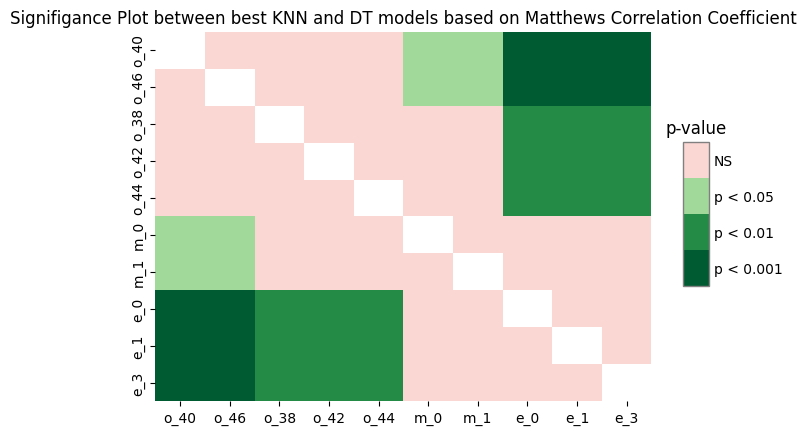

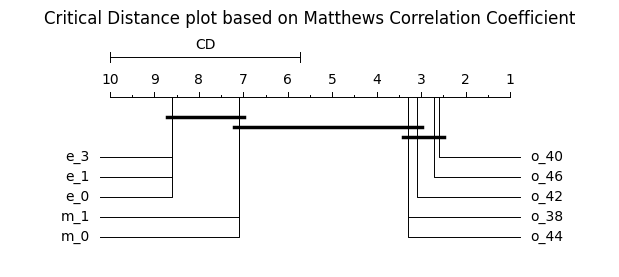

ID: o_40
Parameters: {'criterion': 'entropy', 'max_depth': 41, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9120 ± 0.0018
  - f1_weigthed: 0.9452 ± 0.0011
  - f1_macro: 0.9077 ± 0.0024
------------------------------
ID: o_46
Parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9119 ± 0.0016
  - f1_weigthed: 0.9451 ± 0.0010
  - f1_macro: 0.9083 ± 0.0020
------------------------------
ID: o_38
Parameters: {'criterion': 'entropy', 'max_depth': 39, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9117 ± 0.0017
  - f1_weigthed: 0.9450 ± 0.0010
  - f1_macro: 0.9077 ± 0.0026
------------------------------
ID: o_42
Parameters: {'criterion': 'entropy', 'max_depth': 44, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9117 ± 0.0016
  - f1_weigthed: 0.9450 ± 0.0010
  - f1_macro: 0.9079 ± 0.0022
-------------------

In [123]:
stat_tests(knn_results, dt_results, all_results, 'mcc')

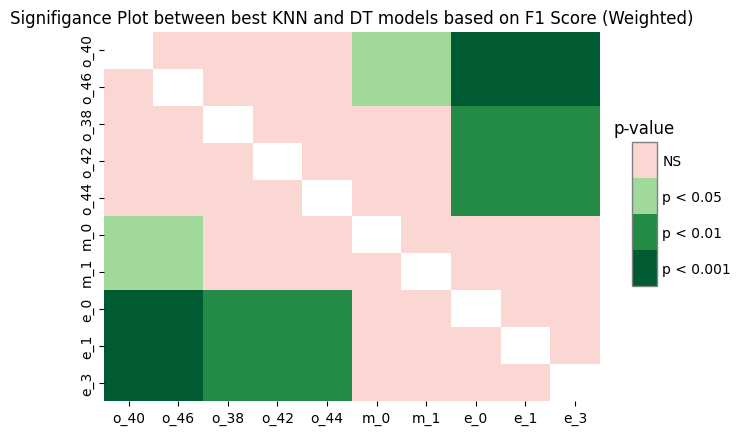

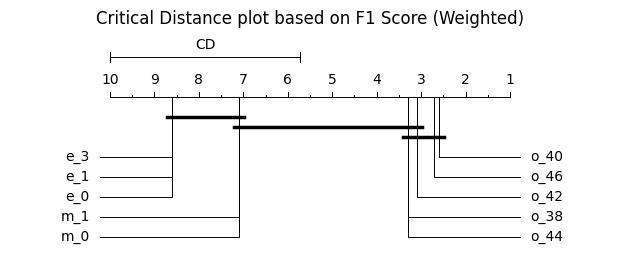

ID: o_40
Parameters: {'criterion': 'entropy', 'max_depth': 41, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9120 ± 0.0018
  - f1_weigthed: 0.9452 ± 0.0011
  - f1_macro: 0.9077 ± 0.0024
------------------------------
ID: o_46
Parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9119 ± 0.0016
  - f1_weigthed: 0.9451 ± 0.0010
  - f1_macro: 0.9083 ± 0.0020
------------------------------
ID: o_38
Parameters: {'criterion': 'entropy', 'max_depth': 39, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9117 ± 0.0017
  - f1_weigthed: 0.9450 ± 0.0010
  - f1_macro: 0.9077 ± 0.0026
------------------------------
ID: o_42
Parameters: {'criterion': 'entropy', 'max_depth': 44, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9117 ± 0.0016
  - f1_weigthed: 0.9450 ± 0.0010
  - f1_macro: 0.9079 ± 0.0022
-------------------

In [126]:
stat_tests(knn_results, dt_results, all_results, 'f1_weigthed')

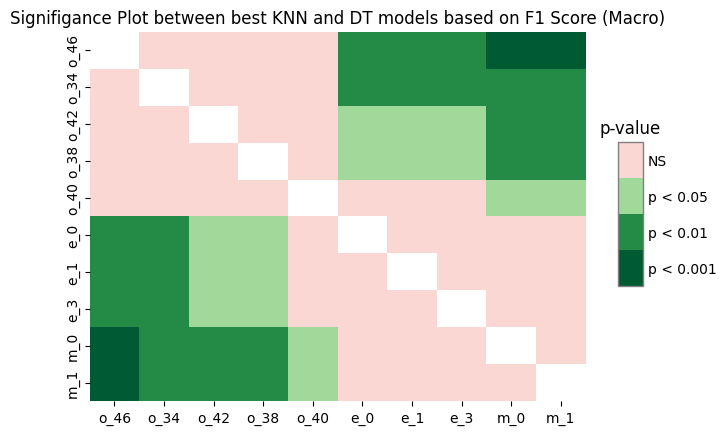

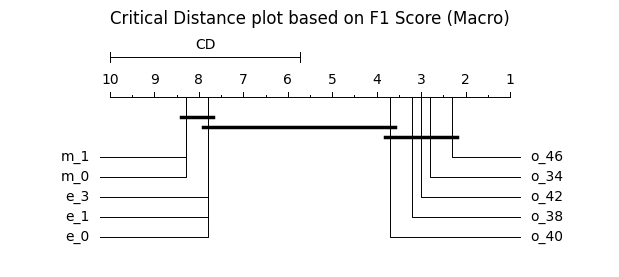

ID: o_46
Parameters: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9119 ± 0.0016
  - f1_weigthed: 0.9451 ± 0.0010
  - f1_macro: 0.9083 ± 0.0020
------------------------------
ID: o_34
Parameters: {'criterion': 'entropy', 'max_depth': 33, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9116 ± 0.0018
  - f1_weigthed: 0.9449 ± 0.0012
  - f1_macro: 0.9082 ± 0.0029
------------------------------
ID: o_42
Parameters: {'criterion': 'entropy', 'max_depth': 44, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9117 ± 0.0016
  - f1_weigthed: 0.9450 ± 0.0010
  - f1_macro: 0.9079 ± 0.0022
------------------------------
ID: o_38
Parameters: {'criterion': 'entropy', 'max_depth': 39, 'min_samples_leaf': 1, 'class_weight': 'balanced', 'resampled': False}
  - mcc: 0.9117 ± 0.0017
  - f1_weigthed: 0.9450 ± 0.0010
  - f1_macro: 0.9077 ± 0.0026
-------------------

In [127]:
stat_tests(knn_results, dt_results, all_results, 'f1_macro')